# Model Clustering - Hotel Dataset

____________

Pada bagian ini, kita akan melakukan clustering pada hotel-hotel yang ada di Labuan Bajo. Clustering yang diharapkan adalah 3 cluster yang sesuai dengan kelas user yaitu Basic, Deluxe, dan King, maka pada bagian ini kita tetapkan n_cluster = 3. Model clustering yang akan kita gunakan adalah model K-Means, Agglomerative Clustering, dan Spectral Clustering. Apabila pada hasil clustering yang didapatkan menghasilkan cluster yang buruk atau tidak sesuai dengan kelas user, maka kita akan menerapkan manual clustering berdasarkan kolom tertentu yang terdapat pada dataset hotel.

---
# Import Libraries

In [22]:
# import library umum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# preprocessing
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

# model
from sklearn.cluster import KMeans, SpectralClustering as SC, AgglomerativeClustering as AC

# metrics
from sklearn.metrics import silhouette_score, silhouette_samples

# code untuk menghilangkan warning
from warnings import filterwarnings
filterwarnings('ignore')

---
# Data Loading

In [2]:
# preview dataset hotel
df_hotel = pd.read_csv('Data\hotel.csv')
df_hotel.head()

,hotel_name,rating,total_review,hotel_star,price,facility_pool,facility_wifi,facility_breakfast,facility_beach_access,facility_pet_friendly,facility_spa,coordinate,image
0,Loccal Collection Hotel,4.2,905,4-star hotel,1930000,Yes,Yes,Yes,Yes,No,Yes,"-8.483960342450034, 119.87987822532138",https://lh5.googleusercontent.com/proxy/tP_a7C...
1,Sunset Hill Hotel,4.1,277,3-star hotel,627000,No,Yes,Yes,No,No,No,"-8.481018332731258, 119.8836460253213",https://lh5.googleusercontent.com/p/AF1QipOlUq...
2,Plataran Komodo Resort & Spa,4.7,562,5-star hotel,4510000,Yes,Yes,Yes,Yes,No,Yes,"-8.456531325825136, 119.87045562532123",https://lh5.googleusercontent.com/p/AF1QipNpwa...
3,Meruorah Komodo Labuan Bajo,4.7,488,5-star hotel,2930000,Yes,Yes,No,Yes,No,Yes,"-8.490100723667199, 119.87555714066441",https://lh3.googleusercontent.com/proxy/gCR1_7...
4,Sylvia Beach Villa,4.2,79,3-star hotel,569000,Yes,Yes,Yes,Yes,No,No,"-8.4621296653001, 119.87294071182824",https://lh3.googleusercontent.com/proxy/3fr3w7...


In [3]:
# nama kolom dataset hotel
df_hotel.columns

Index(['hotel_name', 'rating', 'total_review', 'hotel_star', 'price',
       'facility_pool', 'facility_wifi', 'facility_breakfast',
       'facility_beach_access', 'facility_pet_friendly', 'facility_spa',
       'coordinate', 'image'],
      dtype='object')

In [4]:
# ukuran dimensi dataset hotel
df_hotel.shape

(53, 13)

Terdapat 53 data hotel dengan 13 kolom data.

In [5]:
# informasi dataset hotel
df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hotel_name             53 non-null     object 
 1   rating                 53 non-null     float64
 2   total_review           53 non-null     int64  
 3   hotel_star             53 non-null     object 
 4   price                  53 non-null     int64  
 5   facility_pool          53 non-null     object 
 6   facility_wifi          53 non-null     object 
 7   facility_breakfast     53 non-null     object 
 8   facility_beach_access  53 non-null     object 
 9   facility_pet_friendly  53 non-null     object 
 10  facility_spa           53 non-null     object 
 11  coordinate             53 non-null     object 
 12  image                  53 non-null     object 
dtypes: float64(1), int64(2), object(10)
memory usage: 5.5+ KB


---
# Exploratory Data Analysis

## Distribusi Data Numerik

In [6]:
# membuat fungsi untuk distribusi data menggunakan histogram dan boxplot
def plot_dist(df, col):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    
    # histogram
    sns.histplot(df[col],ax = axes[0], bins=30)
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()
    
    # boxplot
    sns.boxplot(y=df[col], ax =  axes[1])
    axes[1].set_title(f"Boxplot '{col}'")
    
    plt.show()
    
    # skewness
    print('Skewness :', df[col].skew())
    if -0.5 <= df[col].skew() <= 0.5:
        print("Kolom '{}' berdistribusi normal".format(col))
    elif df[col].skew() > 0.5:
        print("Kolom '{}' right skewed (miring ke kanan)".format(col))
    elif df[col].skew() < -0.5:
        print("Kolom '{}' left skewed (miring ke kiri)".format(col))

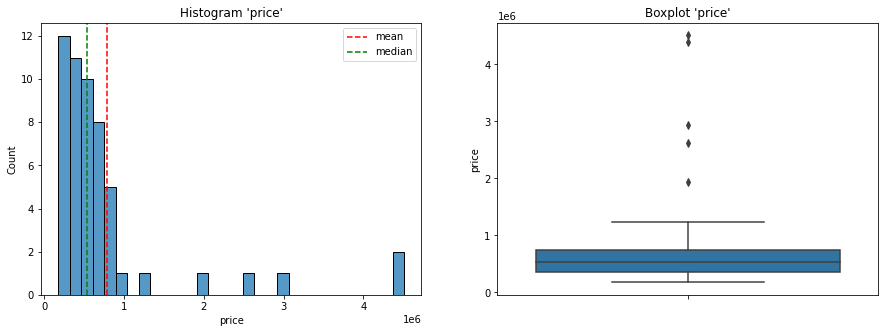

Skewness : 3.1530745524482584
Kolom 'price' right skewed (miring ke kanan)


In [7]:
plot_dist(df_hotel, 'price')

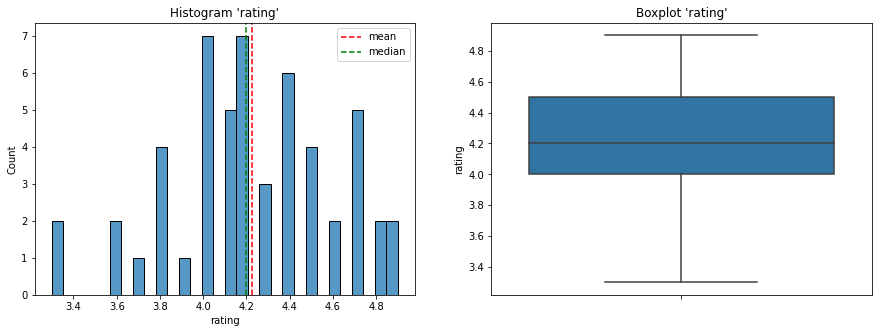

Skewness : -0.3210004585791814
Kolom 'rating' berdistribusi normal


In [8]:
plot_dist(df_hotel, 'rating')

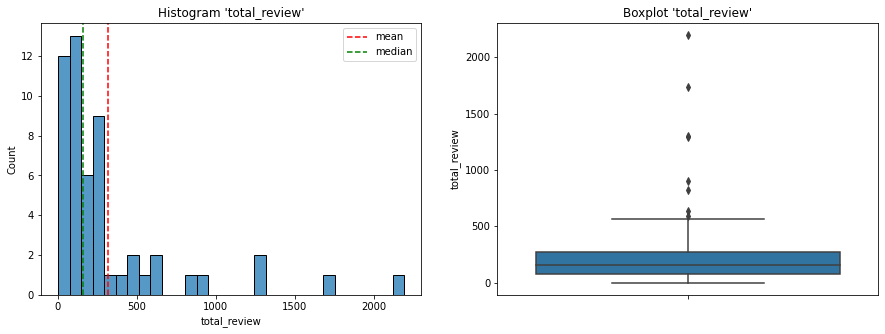

Skewness : 2.672506410647718
Kolom 'total_review' right skewed (miring ke kanan)


In [9]:
plot_dist(df_hotel, 'total_review')

Dari hasil diatas, kita dapat mengetahui bahwa kolom `price` dan kolom `total_review` memiliki distribusi yang tidak normal. Hal ini perlu menjadi catatan pada bagian data preprocessing untuk menggunakan metode scaling yaitu Robust Scaler karena distribusi data numerik tidak normal.

## Analisis Hotel Star

In [9]:
df_hotel['hotel_star'].value_counts()

3-star hotel    25
2-star hotel    11
4-star hotel     8
1-star hotel     5
5-star hotel     4
Name: hotel_star, dtype: int64

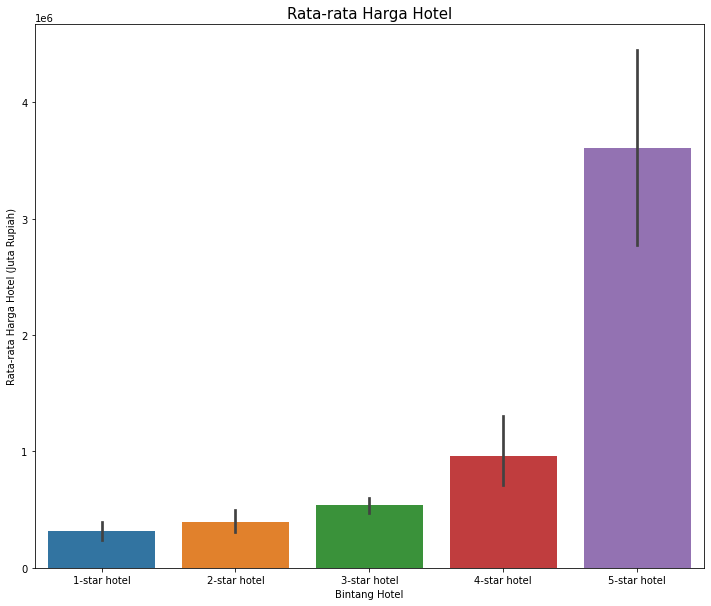

In [10]:
plt.figure(figsize=(12,10))
sns.barplot(data = df_hotel, x = 'hotel_star', y = 'price', order=['1-star hotel', '2-star hotel', '3-star hotel', '4-star hotel', '5-star hotel'])
plt.title('Rata-rata Harga Hotel', size = 15)
plt.xlabel('Bintang Hotel')
plt.ylabel('Rata-rata Harga Hotel (Juta Rupiah)')
plt.show()

In [11]:
print('Rata-rata harga hotel bintang 1 :', np.round(df_hotel[df_hotel['hotel_star'] == '1-star hotel']['price'].mean()))
print('Minimum harga hotel bintang 1 :', np.round(df_hotel[df_hotel['hotel_star'] == '1-star hotel']['price'].min()))
print('Maksimum harga hotel bintang 1 :', np.round(df_hotel[df_hotel['hotel_star'] == '1-star hotel']['price'].max()),'\n')

print('Rata-rata harga hotel bintang 2 :', np.round(df_hotel[df_hotel['hotel_star'] == '2-star hotel']['price'].mean()))
print('Minimum harga hotel bintang 2 :', np.round(df_hotel[df_hotel['hotel_star'] == '2-star hotel']['price'].min()))
print('Maksimum harga hotel bintang 2 :', np.round(df_hotel[df_hotel['hotel_star'] == '2-star hotel']['price'].max()),'\n')

print('Rata-rata harga hotel bintang 3 :', np.round(df_hotel[df_hotel['hotel_star'] == '3-star hotel']['price'].mean()))
print('Minimum harga hotel bintang 3 :', np.round(df_hotel[df_hotel['hotel_star'] == '3-star hotel']['price'].min()))
print('Maksimum harga hotel bintang 3 :', np.round(df_hotel[df_hotel['hotel_star'] == '3-star hotel']['price'].max()),'\n')

print('Rata-rata harga hotel bintang 4 :', np.round(df_hotel[df_hotel['hotel_star'] == '4-star hotel']['price'].mean()))
print('Minimum harga hotel bintang 4 :', np.round(df_hotel[df_hotel['hotel_star'] == '4-star hotel']['price'].min()))
print('Maksimum harga hotel bintang 4 :', np.round(df_hotel[df_hotel['hotel_star'] == '4-star hotel']['price'].max()),'\n')

print('Rata-rata harga hotel bintang 5 :', np.round(df_hotel[df_hotel['hotel_star'] == '5-star hotel']['price'].mean()))
print('Minimum harga hotel bintang 5 :', np.round(df_hotel[df_hotel['hotel_star'] == '5-star hotel']['price'].min()))
print('Maksimum harga hotel bintang 5 :', np.round(df_hotel[df_hotel['hotel_star'] == '5-star hotel']['price'].max()),'\n')

Rata-rata harga hotel bintang 1 : 318600.0
Minimum harga hotel bintang 1 : 176000
Maksimum harga hotel bintang 1 : 438000 

Rata-rata harga hotel bintang 2 : 390455.0
Minimum harga hotel bintang 2 : 200000
Maksimum harga hotel bintang 2 : 655000 

Rata-rata harga hotel bintang 3 : 540880.0
Minimum harga hotel bintang 3 : 270000
Maksimum harga hotel bintang 3 : 893000 

Rata-rata harga hotel bintang 4 : 959250.0
Minimum harga hotel bintang 4 : 535000
Maksimum harga hotel bintang 4 : 1930000 

Rata-rata harga hotel bintang 5 : 3612500.0
Minimum harga hotel bintang 5 : 2620000
Maksimum harga hotel bintang 5 : 4510000 



Berdasarkan analisis kolom `hotel_star` diatas, kita dapat melihat proporsi hotel bintang 1 sampai 5 pada dataset hotel ini. Hotel bintang 3 merupakan hotel paling banyak dengan jumlah 25 hotel. Analisis juga memperlihatkan semakin tinggi bintang hotelnya maka rata-rata harga hotel semakin mahal. Hal ini wajar karena semakin tinggi bintang hotel, maka semakin mahal harga hotel.  
  
Rata-rata harga hotel bintang 1 berada pada harga Rp. 318.600 , sedangkan harga hotel bintang 2 berada pada harga Rp. 390.455. Karena hotel bintang 1 dan 2 ini memiliki rata-rata harga hotel yang mirip, maka kita dapat gabungkan menjadi satu cluster. Rata-rata harga hotel bintang 3 berada pada harga Rp. 540.880, harga hotel bintang 3 ini sudah cukup jauh dengan harga hotel bintang 1 dan 2, sehingga hotel bintang 3 dapat menjadi cluster tersendiri. Rata-rata harga hotel bintang 4 berada pada harga Rp. 959.250, harga ini sudah dapat dikatakan cukup mahal dikalangan user traveler, maka untuk hotel bintang 4 dan 5 akan dapat kita gabungkan menjadi 1 cluster yang sama.  
  
Kesimpulan dari analisis Hotel star ini adalah kita dapat membagi hotel menjadi 3 cluster yaitu sebagai berikut:
1. Hotel bintang 1 dan 2 -> Basic
2. Hotel bintang 3 -> Deluxe
3. Hotel bintang 4 dan 5 -> King  
  

Hasil clustering diatas berdasarkan analisa pada kolom `hotel_star` dan kolom `price`. Apabila pada hasil clustering menggunakan model menghasilkan model clustering yang buruk, maka kita dapat menggunakan clustering berdasarkan hasil analisa diatas.

## Analisis Range Harga Hotel

In [12]:
df_hotel.describe()

,rating,total_review,price
count,53.000000,53.000000,5.300000e+01
mean,4.224528,317.415094,7.836604e+05
std,0.380236,438.963264,8.971595e+05
min,3.300000,2.000000,1.760000e+05
25%,4.000000,77.000000,3.510000e+05
50%,4.200000,160.000000,5.350000e+05
75%,4.500000,277.000000,7.440000e+05
max,4.900000,2192.000000,4.510000e+06


In [14]:
df_basic = df_hotel[df_hotel['price'] <= 400000]

In [15]:
df_deluxe = df_hotel[(df_hotel['price'] >= 400000) & (df_hotel['price'] <= 900000)]

In [16]:
df_king = df_hotel[df_hotel['price'] >= 900000]

In [17]:
print(df_basic.shape[0] + df_deluxe.shape[0] + df_king.shape[0])

53


In [13]:
hotel_cluster = []

for i in df_hotel['price']:
    if  i <= 400000:
        hotel_cluster.append('Basic')
    elif 400000 <= i <= 900000:
        hotel_cluster.append('Deluxe')
    else:
        hotel_cluster.append('King')

In [14]:
hotel_cluster[:5]

['King', 'Deluxe', 'King', 'King', 'Deluxe']

In [15]:
df_hotel['cluster_hotel'] = hotel_cluster

In [16]:
df_hotel.head()

,hotel_name,rating,total_review,hotel_star,price,facility_pool,facility_wifi,facility_breakfast,facility_beach_access,facility_pet_friendly,facility_spa,coordinate,image,cluster_hotel
0,Loccal Collection Hotel,4.2,905,4-star hotel,1930000,Yes,Yes,Yes,Yes,No,Yes,"-8.483960342450034, 119.87987822532138",https://lh5.googleusercontent.com/proxy/tP_a7C...,King
1,Sunset Hill Hotel,4.1,277,3-star hotel,627000,No,Yes,Yes,No,No,No,"-8.481018332731258, 119.8836460253213",https://lh5.googleusercontent.com/p/AF1QipOlUq...,Deluxe
2,Plataran Komodo Resort & Spa,4.7,562,5-star hotel,4510000,Yes,Yes,Yes,Yes,No,Yes,"-8.456531325825136, 119.87045562532123",https://lh5.googleusercontent.com/p/AF1QipNpwa...,King
3,Meruorah Komodo Labuan Bajo,4.7,488,5-star hotel,2930000,Yes,Yes,No,Yes,No,Yes,"-8.490100723667199, 119.87555714066441",https://lh3.googleusercontent.com/proxy/gCR1_7...,King
4,Sylvia Beach Villa,4.2,79,3-star hotel,569000,Yes,Yes,Yes,Yes,No,No,"-8.4621296653001, 119.87294071182824",https://lh3.googleusercontent.com/proxy/3fr3w7...,Deluxe


In [17]:
df_hotel['cluster_hotel'].value_counts()

Deluxe    31
Basic     15
King       7
Name: cluster_hotel, dtype: int64

In [23]:
df_hotel.to_csv('hotel_final.csv', index = False)

In [18]:
df_hotel['overall_score'] = df_hotel['rating'] * 0.75 + df_hotel['total_review'] * 0.25

In [21]:
df_scaled = df_hotel[['rating','total_review']]
df_scaled.head()

,rating,total_review
0,4.2,905
1,4.1,277
2,4.7,562
3,4.7,488
4,4.2,79


In [52]:
scaler = MinMaxScaler()

In [53]:
df_scaled = scaler.fit_transform(df_scaled)

In [54]:
scaled_df = pd.DataFrame(df_scaled, columns = ['rating_scaled','review_scaled'])
scaled_df.head()

,rating_scaled,review_scaled
0,0.5625,0.412329
1,0.5000,0.125571
2,0.8750,0.255708
3,0.8750,0.221918
4,0.5625,0.035160


In [55]:
# Merge dataframe inference dengan prediksi model
df_hotel_final = pd.concat([df_hotel, scaled_df], axis = 1)

In [56]:
df_hotel_final['overall_score'] = df_hotel_final['rating_scaled'] * 0.7 + df_hotel_final['review_scaled'] * 0.3

In [57]:
df_hotel_final[df_hotel_final['cluster_hotel'] == 'King'].sort_values('overall_score', ascending=False)

,hotel_name,rating,total_review,hotel_star,price,facility_pool,facility_wifi,facility_breakfast,facility_beach_access,facility_pet_friendly,facility_spa,coordinate,image,cluster_hotel,overall_score,rating_scaled,review_scaled
5,AYANA Komodo Resort,4.8,2192,5-star hotel,4390000,Yes,Yes,Yes,Yes,No,Yes,"-8.467415214884218, 119.874280488684",https://lh5.googleusercontent.com/p/AF1QipOEVL...,King,0.956250,0.9375,1.000000
2,Plataran Komodo Resort & Spa,4.7,562,5-star hotel,4510000,Yes,Yes,Yes,Yes,No,Yes,"-8.456531325825136, 119.87045562532123",https://lh5.googleusercontent.com/p/AF1QipNpwa...,King,0.689212,0.8750,0.255708
3,Meruorah Komodo Labuan Bajo,4.7,488,5-star hotel,2930000,Yes,Yes,No,Yes,No,Yes,"-8.490100723667199, 119.87555714066441",https://lh3.googleusercontent.com/proxy/gCR1_7...,King,0.679075,0.8750,0.221918
37,Laprima Hotel,4.3,1734,4-star hotel,916000,Yes,No,Yes,No,No,Yes,"-8.504417769950372, 119.87869669648593",https://lh6.googleusercontent.com/proxy/CXXJbE...,King,0.674760,0.6250,0.790868
33,Bintang Flores Hotel,4.4,1292,4-star hotel,1240000,Yes,Yes,Yes,No,No,No,"-8.510840668598057, 119.87692874689506",https://lh5.googleusercontent.com/p/AF1QipPiVJ...,King,0.657962,0.6875,0.589041
20,"Sudamala Resort, Komodo",4.5,203,5-star hotel,2620000,Yes,Yes,Yes,No,No,No,"-8.513792448518869, 119.87625914066476",https://lh5.googleusercontent.com/proxy/9e1EYd...,King,0.552534,0.7500,0.091781
0,Loccal Collection Hotel,4.2,905,4-star hotel,1930000,Yes,Yes,Yes,Yes,No,Yes,"-8.483960342450034, 119.87987822532138",https://lh5.googleusercontent.com/proxy/tP_a7C...,King,0.517449,0.5625,0.412329


In [61]:
df_hotel_final['lat'] = df_hotel_final['coordinate'].str.split(', ').str[0]
df_hotel_final['lon'] = df_hotel_final['coordinate'].str.split(', ').str[1]

In [63]:
df_hotel_final.head()

,hotel_name,rating,total_review,hotel_star,price,facility_pool,facility_wifi,facility_breakfast,facility_beach_access,facility_pet_friendly,facility_spa,coordinate,image,cluster_hotel,overall_score,rating_scaled,review_scaled,lat,lon
0,Loccal Collection Hotel,4.2,905,4-star hotel,1930000,Yes,Yes,Yes,Yes,No,Yes,"-8.483960342450034, 119.87987822532138",https://lh5.googleusercontent.com/proxy/tP_a7C...,King,0.517449,0.5625,0.412329,-8.483960342450034,119.87987822532138
1,Sunset Hill Hotel,4.1,277,3-star hotel,627000,No,Yes,Yes,No,No,No,"-8.481018332731258, 119.8836460253213",https://lh5.googleusercontent.com/p/AF1QipOlUq...,Deluxe,0.387671,0.5000,0.125571,-8.481018332731258,119.8836460253213
2,Plataran Komodo Resort & Spa,4.7,562,5-star hotel,4510000,Yes,Yes,Yes,Yes,No,Yes,"-8.456531325825136, 119.87045562532123",https://lh5.googleusercontent.com/p/AF1QipNpwa...,King,0.689212,0.8750,0.255708,-8.456531325825136,119.87045562532123
3,Meruorah Komodo Labuan Bajo,4.7,488,5-star hotel,2930000,Yes,Yes,No,Yes,No,Yes,"-8.490100723667199, 119.87555714066441",https://lh3.googleusercontent.com/proxy/gCR1_7...,King,0.679075,0.8750,0.221918,-8.490100723667199,119.87555714066441
4,Sylvia Beach Villa,4.2,79,3-star hotel,569000,Yes,Yes,Yes,Yes,No,No,"-8.4621296653001, 119.87294071182824",https://lh3.googleusercontent.com/proxy/3fr3w7...,Deluxe,0.404298,0.5625,0.035160,-8.4621296653001,119.87294071182824


In [64]:
df_hotel_final.to_csv('hotel_final.csv', index = False)

In [ ]:
df[df['hotel'] == a]

# Coba

In [68]:
df_hotel_final[(df_hotel_final['cluster_hotel'] == 'King') & (df_hotel_final['facility_pool'] == 'Yes') & (df_hotel_final['facility_breakfast'] == 'Yes')]

,hotel_name,rating,total_review,hotel_star,price,facility_pool,facility_wifi,facility_breakfast,facility_beach_access,facility_pet_friendly,facility_spa,coordinate,image,cluster_hotel,overall_score,rating_scaled,review_scaled,lat,lon
0,Loccal Collection Hotel,4.2,905,4-star hotel,1930000,Yes,Yes,Yes,Yes,No,Yes,"-8.483960342450034, 119.87987822532138",https://lh5.googleusercontent.com/proxy/tP_a7C...,King,0.517449,0.5625,0.412329,-8.483960342450034,119.87987822532138
2,Plataran Komodo Resort & Spa,4.7,562,5-star hotel,4510000,Yes,Yes,Yes,Yes,No,Yes,"-8.456531325825136, 119.87045562532123",https://lh5.googleusercontent.com/p/AF1QipNpwa...,King,0.689212,0.8750,0.255708,-8.456531325825136,119.87045562532123
5,AYANA Komodo Resort,4.8,2192,5-star hotel,4390000,Yes,Yes,Yes,Yes,No,Yes,"-8.467415214884218, 119.874280488684",https://lh5.googleusercontent.com/p/AF1QipOEVL...,King,0.956250,0.9375,1.000000,-8.467415214884218,119.874280488684
20,"Sudamala Resort, Komodo",4.5,203,5-star hotel,2620000,Yes,Yes,Yes,No,No,No,"-8.513792448518869, 119.87625914066476",https://lh5.googleusercontent.com/proxy/9e1EYd...,King,0.552534,0.7500,0.091781,-8.513792448518869,119.87625914066476
33,Bintang Flores Hotel,4.4,1292,4-star hotel,1240000,Yes,Yes,Yes,No,No,No,"-8.510840668598057, 119.87692874689506",https://lh5.googleusercontent.com/p/AF1QipPiVJ...,King,0.657962,0.6875,0.589041,-8.510840668598057,119.87692874689506
37,Laprima Hotel,4.3,1734,4-star hotel,916000,Yes,No,Yes,No,No,Yes,"-8.504417769950372, 119.87869669648593",https://lh6.googleusercontent.com/proxy/CXXJbE...,King,0.674760,0.6250,0.790868,-8.504417769950372,119.87869669648593


---
# Data Preprocessing

## Split Fitur (X) dan Kolom ID (X_id)

In [10]:
X_id = df_hotel['hotel_name']
X = df_hotel.drop(['hotel_name', 'facility_pool', 'facility_wifi', 'facility_breakfast', 'facility_beach_access', 'facility_pet_friendly', 'facility_spa', 'coordinate', 'image'], axis = 1)

In [12]:
X_id.head()

0         Loccal Collection Hotel
1               Sunset Hill Hotel
2    Plataran Komodo Resort & Spa
3     Meruorah Komodo Labuan Bajo
4              Sylvia Beach Villa
Name: hotel_name, dtype: object

In [13]:
X.head()

,rating,total_review,hotel_star,price
0,4.2,905,4-star hotel,1930000
1,4.1,277,3-star hotel,627000
2,4.7,562,5-star hotel,4510000
3,4.7,488,5-star hotel,2930000
4,4.2,79,3-star hotel,569000


In [32]:
X_num = X[['rating','total_review','price']]
X_num.head()

,rating,total_review,price
0,4.2,905,1930000
1,4.1,277,627000
2,4.7,562,4510000
3,4.7,488,2930000
4,4.2,79,569000


In [37]:
X_cat = X[['hotel_star']]
X_cat.head()

,hotel_star
0,4-star hotel
1,3-star hotel
2,5-star hotel
3,5-star hotel
4,3-star hotel


## Cek VIF Data Numerik

In [19]:
# dataframe baru untuk melihat hasil VIF
vif_data = pd.DataFrame()
vif_data["Fitur"] = X_num.columns

# menghitung nilai VIF pada masing-masing fitur
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(len(X_num.columns))]
vif_data.sort_values(by = "VIF", ascending=False)

,Fitur,VIF
2,price,2.527458
1,total_review,2.105580
0,rating,1.974815


Hasil VIF menunjukan dibawah 5 yang artinya fitur independen terhadap fitur lainnya

## Scaling Data Numerik

In [33]:
# scaling data numerik
scaler = RobustScaler()
X_num_scaled = scaler.fit_transform(X_num)

## Encoding Data Kategorik

In [39]:
encoder = OrdinalEncoder()
X_cat_encoded = encoder.fit_transform(X_cat)

In [53]:
X_cat.head()

,hotel_star
0,4-star hotel
1,3-star hotel
2,5-star hotel
3,5-star hotel
4,3-star hotel


In [54]:
X_cat_encoded[:5]

array([[3.],
       [2.],
       [4.],
       [4.],
       [2.]])

## Concatenate Hasil Scaling dan Encoding

In [48]:
X_final = np.concatenate([X_num_scaled, X_cat_encoded], axis = 1)

In [50]:
X_final[:5]

array([[ 0.        ,  3.725     ,  3.54961832,  3.        ],
       [-0.2       ,  0.585     ,  0.23409669,  2.        ],
       [ 1.        ,  2.01      , 10.11450382,  4.        ],
       [ 1.        ,  1.64      ,  6.09414758,  4.        ],
       [ 0.        , -0.405     ,  0.08651399,  2.        ]])

In [51]:
X_final.shape

(53, 4)

## PCA

In [165]:
# PCA dengan jumlah komponen sebanyak 10
pca = PCA(n_components=3).fit(X_final)
pca.explained_variance_ratio_

array([0.70429099, 0.21126041, 0.04465789])

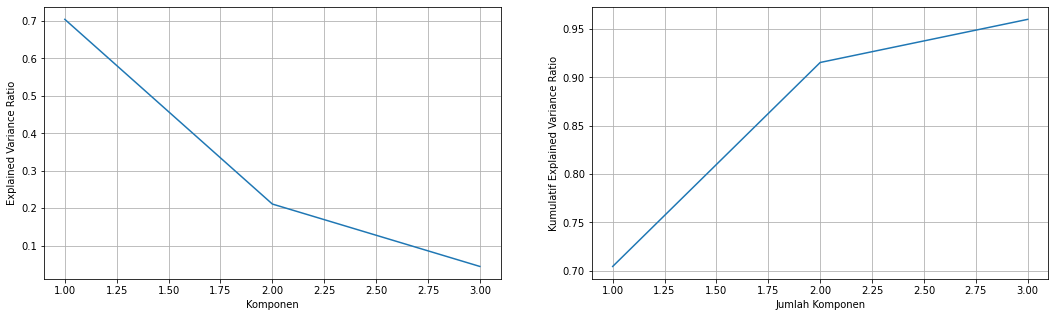

In [167]:
# visualisasi PCA dengan menggunakan elbow method
fig,ax=plt.subplots(ncols=2,figsize=(18,5))
ax[0].plot(range(1,4),pca.explained_variance_ratio_)
ax[0].set_xlabel('Komponen')
ax[0].set_ylabel('Explained Variance Ratio')
ax[0].grid()

ax[1].plot(range(1,4),np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Jumlah Komponen')
ax[1].set_ylabel('Kumulatif Explained Variance Ratio')
ax[1].grid()
plt.show()

In [168]:
# finalisasi pca dengan jumlah komponen terbaik
pca_final = PCA(n_components=2)
X_final_pca = pca_final.fit_transform(X_final)

In [169]:
# hasil kumulatif EVR
np.sum(pca_final.explained_variance_ratio_)

0.9155514009374445

In [170]:
# dimensi data untuk pemodelan
X_final_pca.shape

(53, 2)

# Model Definition

In [130]:
# model clustering
kmeans = KMeans(n_clusters=5, random_state=100)
agg_clust = AC(linkage='ward')
scl = SC(n_clusters = 2, gamma= 0.01)

## K-Means

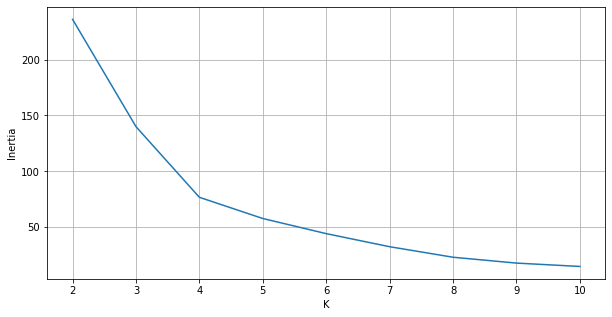

In [171]:
# training model K-Means
K=[2,3,4,5,6,7,8,9,10]
inertia=[KMeans(n_clusters=i).fit(X_final_pca).inertia_ for i in K]
plt.figure(figsize=(10,5))
plt.plot(K,inertia)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.grid()
plt.show()

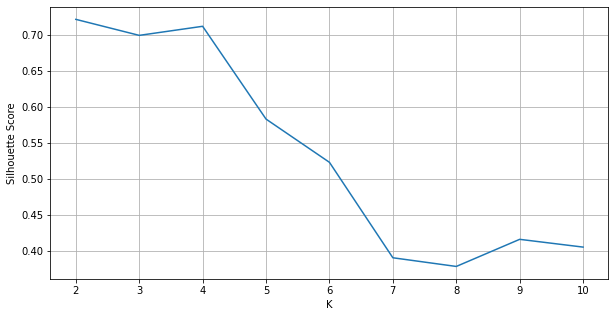

In [179]:
# training model KMeans
K=[2,3,4,5,6,7,8,9,10]
s_score=[silhouette_score(X_final_pca, KMeans(n_clusters=i).fit(X_final_pca).labels_) for i in K]
plt.figure(figsize=(10,5))
plt.plot(K,s_score)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

In [186]:
# model KMeans dengan jumlah cluster terbaik
kmeans_best = KMeans(n_clusters=3, random_state=100)

# fit model KMeans pada data
kmeans_best.fit(X_final_pca)

KMeans(n_clusters=3, random_state=100)

In [187]:
# label / hasil clustering dari model KMeans
kmeans_best.labels_

array([1, 0, 2, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0])

In [188]:
kmeans_df = pd.DataFrame(kmeans_best.labels_, columns = ['kmeans'])
kmeans_df.value_counts()

kmeans
0         44
1          5
2          4
dtype: int64

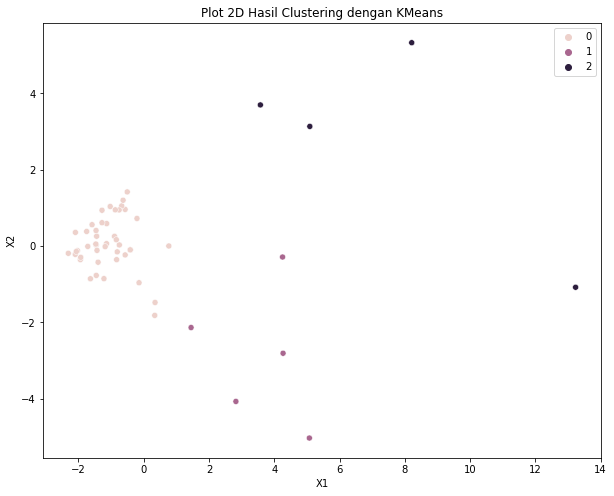

In [176]:
# visualisasi hasil clustering pada plot 2 dimensi
plt.figure(figsize=(10,8))
sns.scatterplot(x=X_final_pca[:,0],y=X_final_pca[:,1],hue=kmeans_best.labels_)
plt.title('Plot 2D Hasil Clustering dengan KMeans')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## Agglomerative Clustering

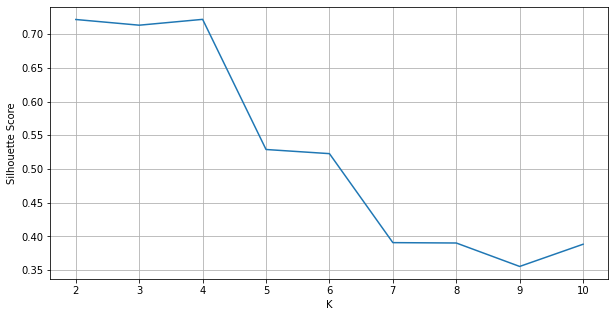

In [178]:
# training model Agglomerative Clustering
K=[2,3,4,5,6,7,8,9,10]
s_score_ac=[silhouette_score(X_final_pca, AC(n_clusters=i).fit(X_final_pca).labels_) for i in K]
plt.figure(figsize=(10,5))
plt.plot(K,s_score_ac)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

In [190]:
# model Agglomerative dengan jumlah cluster terbaik
agg_clust_final = AC(n_clusters=3, linkage='ward')

In [191]:
# model Agglomerative Clustering fit pada data
agg_clust_final.fit(X_final_pca)

AgglomerativeClustering(n_clusters=3)

In [192]:
# label / hasil clustering dari model Agglomerative Clustering
agg_clust_final.labels_

array([0, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [193]:
agg_df = pd.DataFrame(agg_clust_final.labels_, columns = ['agg'])
agg_df.value_counts()

agg
1      45
0       5
2       3
dtype: int64

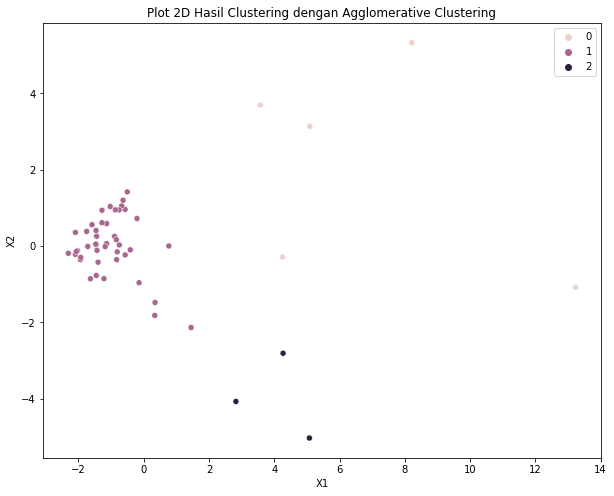

In [194]:
# visualisasi hasil Agglomerative clustering pada plot 2 dimensi
plt.figure(figsize=(10,8))
sns.scatterplot(x=X_final_pca[:,0],y=X_final_pca[:,1],hue=agg_clust_final.labels_)
plt.title('Plot 2D Hasil Clustering dengan Agglomerative Clustering')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## Spectral Clustering

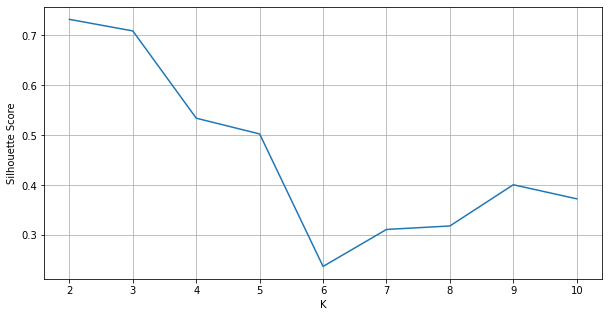

In [195]:
# training moddel Spectral Clustering
K=[2,3,4,5,6,7,8,9,10]
s_score_slc=[silhouette_score(X_final_pca, SC(n_clusters=i).fit(X_final_pca).labels_) for i in K]
plt.figure(figsize=(10,5))
plt.plot(K,s_score_slc)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

In [196]:
# model Agglomerative dengan jumlah cluster terbaik
sc_clust_final = SC(n_clusters=3)

In [197]:
# model Agglomerative Clustering fit pada data
sc_clust_final.fit(X_final_pca)

SpectralClustering(n_clusters=3)

In [198]:
# label / hasil clustering dari model Agglomerative Clustering
sc_clust_final.labels_

array([1, 0, 2, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [199]:
sc_df = pd.DataFrame(sc_clust_final.labels_, columns = ['sc'])
sc_df.value_counts()

sc
0     45
1      4
2      4
dtype: int64

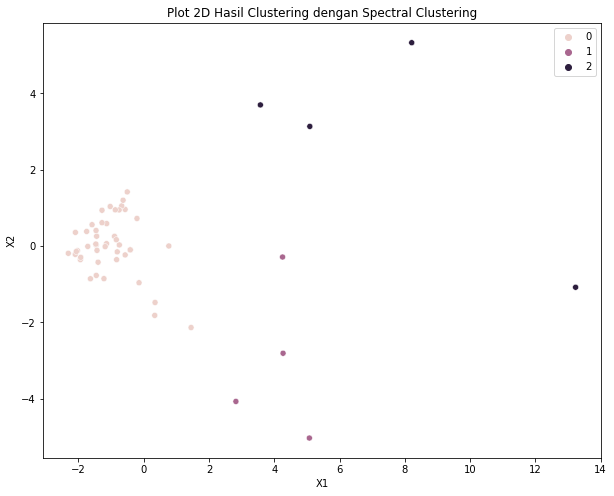

In [200]:
# visualisasi hasil Agglomerative clustering pada plot 2 dimensi
plt.figure(figsize=(10,8))
sns.scatterplot(x=X_final_pca[:,0],y=X_final_pca[:,1],hue=sc_clust_final.labels_)
plt.title('Plot 2D Hasil Clustering dengan Spectral Clustering')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Manual Clustering

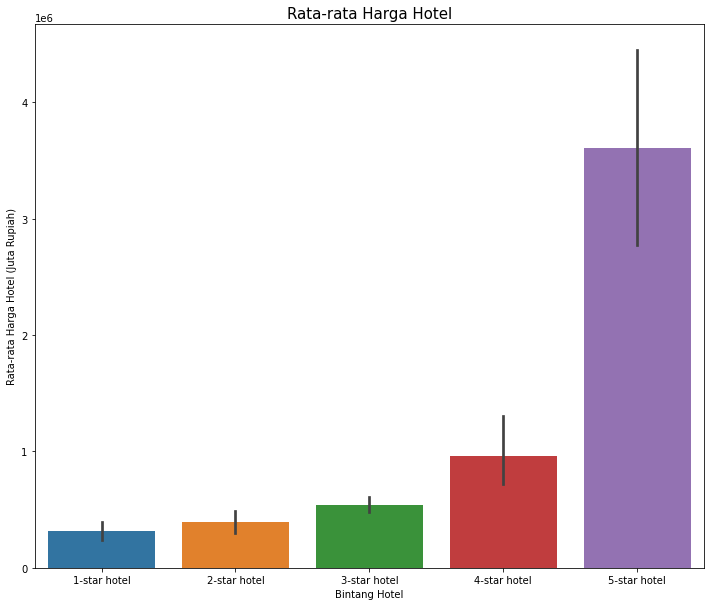

In [208]:
plt.figure(figsize=(12,10))
sns.barplot(data = df_hotel, x = 'hotel_star', y = 'price', order=['1-star hotel', '2-star hotel', '3-star hotel', '4-star hotel', '5-star hotel'])
plt.title('Rata-rata Harga Hotel', size = 15)
plt.xlabel('Bintang Hotel')
plt.ylabel('Rata-rata Harga Hotel (Juta Rupiah)')
plt.show()

In [222]:
print('Rata-rata harga hotel bintang 1 :', np.round(df_hotel[df_hotel['hotel_star'] == '1-star hotel']['price'].mean()))
print('Minimum harga hotel bintang 1 :', np.round(df_hotel[df_hotel['hotel_star'] == '1-star hotel']['price'].min()))
print('Maksimum harga hotel bintang 1 :', np.round(df_hotel[df_hotel['hotel_star'] == '1-star hotel']['price'].max()),'\n')

print('Rata-rata harga hotel bintang 2 :', np.round(df_hotel[df_hotel['hotel_star'] == '2-star hotel']['price'].mean()))
print('Minimum harga hotel bintang 2 :', np.round(df_hotel[df_hotel['hotel_star'] == '2-star hotel']['price'].min()))
print('Maksimum harga hotel bintang 2 :', np.round(df_hotel[df_hotel['hotel_star'] == '2-star hotel']['price'].max()),'\n')

print('Rata-rata harga hotel bintang 3 :', np.round(df_hotel[df_hotel['hotel_star'] == '3-star hotel']['price'].mean()))
print('Minimum harga hotel bintang 3 :', np.round(df_hotel[df_hotel['hotel_star'] == '3-star hotel']['price'].min()))
print('Maksimum harga hotel bintang 3 :', np.round(df_hotel[df_hotel['hotel_star'] == '3-star hotel']['price'].max()),'\n')

print('Rata-rata harga hotel bintang 4 :', np.round(df_hotel[df_hotel['hotel_star'] == '4-star hotel']['price'].mean()))
print('Minimum harga hotel bintang 4 :', np.round(df_hotel[df_hotel['hotel_star'] == '4-star hotel']['price'].min()))
print('Maksimum harga hotel bintang 4 :', np.round(df_hotel[df_hotel['hotel_star'] == '4-star hotel']['price'].max()),'\n')

print('Rata-rata harga hotel bintang 5 :', np.round(df_hotel[df_hotel['hotel_star'] == '5-star hotel']['price'].mean()))
print('Minimum harga hotel bintang 5 :', np.round(df_hotel[df_hotel['hotel_star'] == '5-star hotel']['price'].min()))
print('Maksimum harga hotel bintang 5 :', np.round(df_hotel[df_hotel['hotel_star'] == '5-star hotel']['price'].max()),'\n')

Rata-rata harga hotel bintang 1 : 318600.0
Minimum harga hotel bintang 1 : 176000
Maksimum harga hotel bintang 1 : 438000 

Rata-rata harga hotel bintang 2 : 390455.0
Minimum harga hotel bintang 2 : 200000
Maksimum harga hotel bintang 2 : 655000 

Rata-rata harga hotel bintang 3 : 540880.0
Minimum harga hotel bintang 3 : 270000
Maksimum harga hotel bintang 3 : 893000 

Rata-rata harga hotel bintang 4 : 959250.0
Minimum harga hotel bintang 4 : 535000
Maksimum harga hotel bintang 4 : 1930000 

Rata-rata harga hotel bintang 5 : 3612500.0
Minimum harga hotel bintang 5 : 2620000
Maksimum harga hotel bintang 5 : 4510000 



## Kesimpulan Clustering

Clustering menggunakan model menghasilkan clustering yang buruk untuk diimplementasikan pada dataset hotel ini, sehingga metode clustering yang kita gunakan adalah metode manual berdasarkan EDA dari dataset hotel. Hasil EDA menunjukan bahwa kita dapat membagi cluster hotel ini menjadi 3 cluster sesuai dengan klasifikasi user yaitu Basic, Deluxe, dan King. Hotel bintang 1 dan bintang 2 dapat dijadikan sebagai cluster Basic, hotel bintang 3 dapat dijadikan sebagai cluster Deluxe, dan hotel bintang 4 dan bintang 5 dapat dijadikan sebagai cluster King.

# Cluster Hotel

In [225]:
df_hotel['cluster_hotel'] = df_hotel['hotel_star'].map({'1-star hotel' : 'Basic', '2-star hotel' : 'Basic', '3-star hotel' : 'Deluxe', '4-star hotel' : 'King', '5-star hotel' : 'King'})

In [228]:
df_hotel['cluster_hotel'].value_counts()

Deluxe    25
Basic     16
King      12
Name: cluster_hotel, dtype: int64